# **Zee Recommender Systems**

### **Problem Statement**
Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

### **Data Dictionary:**

##### > **RATINGS FILE DESCRIPTION**


All ratings are contained in the file "ratings.dat" and are in the following format:

* UserID::MovieID::Rating::Timestamp

* UserIDs range between 1 and 6040

* MovieIDs range between 1 and 3952

* Ratings are made on a 5-star scale (whole-star ratings only)

* Timestamp is represented in seconds

* Each user has at least 20 ratings

##### > **USERS FILE DESCRIPTION**


* User information is in the file "users.dat" and is in the following format:

* UserID :: Gender :: Age :: Occupation :: Zip-code

All demographic information is provided voluntarily by the users and is not checked for accuracy.
Only users who have provided some demographic information are included in this data set.

* Gender is denoted by a "M" for male and "F" for female

* Age is chosen from the following ranges:

    > * 1: "Under 18"
    > * 18: "18-24"
    > * 25: "25-34"
    > * 35: "35-44"
    > * 45: "45-49"
    > * 50: "50-55"
    > * 56: "56+"

* Occupation is chosen from the following choices:

    > * 0: "other" or not specified
    > * 1: "academic/educator"
    > * 2: "artist"
    > * 3: "clerical/admin"
    > * 4: "college/grad student"
    > * 5: "customer service"
    > * 6: "doctor/health care"
    > * 7: "executive/managerial"
    > * 8: "farmer"
    > * 9: "homemaker"
    > * 10: "K-12 student"
    > * 11: "lawyer"
    > * 12: "programmer"
    > * 13: "retired"
    > * 14: "sales/marketing"
    > * 15: "scientist"
    > * 16: "self-employed"
    > * 17: "technician/engineer"
    > * 18: "tradesman/craftsman"
    > * 19: "unemployed"
    > * 20: "writer"

#### >  **MOVIES FILE DESCRIPTION**

Movie information is in the file "movies.dat" and is in the following format:

* MovieID::Title::Genres

* Titles are identical to titles provided by the IMDB (including year of release)

* Genres are pipe-separated and are selected from the following genres:

    > * Action
    > * Adventure
    > * Animation
    > * Children's
    > * Comedy
    > * Crime
    > * Documentary
    > * Drama
    > * Fantasy
    > * Film-Noir
    > * Horror
    > * Musical
    > * Mystery
    > * Romance
    > * Sci-Fi
    > * Thriller
    > * War
    > * Western

### **Concepts Tested:**

* **Recommender Engine**
* **Collaborative Filtering (Item-based & User-based Approach)**
* **Pearson Correlation**
* **Nearest Neighbors using Cosine Similarity**
* **Matrix Factorization**

* Build a Recommender System based Pearson Correlation.

        * Using the User-based approach 
        * Using the Item-based approach 

* Build a Recommender System that uses Nearest Neighbors algorithm and Cosine Similarity.

        * Using the Item-based approach 
        * Using User-based approach
    
* Build a Recommender System based on Matrix Factorization.

In [1]:
# ! pip install cmfrec

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from cmfrec import CMF
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

import warnings
warnings.filterwarnings('ignore')

In [3]:
movies = pd.read_fwf('zee-movies.dat', encoding='ISO-8859-1')
movies.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [4]:
movies.shape

(3883, 3)

In [5]:
movies.drop(columns=['Unnamed: 1','Unnamed: 2'], inplace=True)
movies.head()

,Movie ID::Title::Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy
2,3::Grumpier Old Men (1995)::Comedy|Romance
3,4::Waiting to Exhale (1995)::Comedy|Drama
4,5::Father of the Bride Part II (1995)::Comedy


In [6]:
movies = movies['Movie ID::Title::Genres'].str.split("::", expand=True)
movies.columns = ['MovieID', 'Title', 'Genres']
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
movies['Year'] = movies.Title.str.extract('(\(\d+\))', expand=False)
movies['Year'] = movies.Year.str.extract('(\d+)', expand=False)
movies['Title'] = movies.Title.str.replace('(\(\d+\))', "")
movies['Title'] = movies['Title'].apply(lambda x: x.strip())
movies.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


In [8]:
movies.isna().sum()

MovieID     0
Title       0
Genres     25
Year       19
dtype: int64

In [9]:
moviesCopy = movies.copy()
moviesCopy.dropna(inplace=True)
moviesCopy.Genres = moviesCopy.Genres.str.split('|')
moviesCopy['Genres'] = moviesCopy['Genres'].apply(lambda x: [i for i in x if i!='A' and i!='D' and i!= 'F' and i!='C' and i!='M' and i!= 'W' and i!= ' '])
for i in moviesCopy['Genres']:
    for j in range(len(i)):
        if i[j] == 'Ro' or i[j] == 'Rom' or i[j] == 'Roman' or i[j] == 'R' or i[j] == 'Roma':
            i[j] = 'Romance'
        elif i[j] == 'Chil' or i[j] == 'Childre' or i[j] == 'Childr' or i[j] == "Children'" or i[j] =='Children' or i[j] =='Chi':
            i[j] = "Children's"
        elif i[j] == 'Fantas' or i[j] == 'Fant':
            i[j] = 'Fantasy'
        elif i[j] == 'Dr' or i[j] == 'Dram':
            i[j] = 'Drama'
        elif i[j] == 'Documenta'or i[j] == 'Docu' or i[j] == 'Document' or i[j] == 'Documen':
            i[j] = 'Documentary'
        elif i[j] == 'Wester'or i[j] == 'We':
            i[j] = 'Western'
        elif i[j] == 'Animati':
            i[j] = 'Animation'
        elif i[j] == 'Come'or i[j] == 'Comed' or i[j] == 'Com':
            i[j] = 'Comedy'
        elif i[j] == 'Sci-F'or i[j] == 'S' or i[j] == 'Sci-' or i[j] == 'Sci':
            i[j] = 'Sci-Fi'
        elif i[j] == 'Adv'or i[j] == 'Adventu' or i[j] == 'Adventur' or i[j] == 'Advent':
            i[j] = 'Adventure'
        elif i[j] == 'Horro'or i[j] == 'Horr':
            i[j] = 'Horror'
        elif i[j] == 'Th'or i[j] == 'Thri' or i[j] == 'Thrille':
            i[j] = 'Thriller'
        elif i[j] == 'Acti':
            i[j] = 'Action'
        elif i[j] == 'Wa':
            i[j] = 'War'
        elif i[j] == 'Music':
            i[j] = 'Musical'
moviesCopy.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [10]:
moviesCopy.shape

(3858, 4)

In [11]:
ratings = pd.read_fwf('zee-ratings.dat', encoding='ISO-8859-1')
ratings.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [12]:
ratings.shape

(1000209, 1)

In [13]:
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split("::", expand=True)
ratings.columns = ['UserID', 'MovieID', 'Rating','Timestamp']
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [14]:
ratings.isna().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [15]:
users = pd.read_fwf('zee-users.dat', encoding='ISO-8859-1')
users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [16]:
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split("::", expand=True)
users.columns = ['UserID', 'Gender', 'Age','Occupation', 'Zip_code']
users.head()

,UserID,Gender,Age,Occupation,Zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [17]:
users.replace({'Age':{'1':  "Under 18",
                      '18':  "18-24",
                      '25':  "25-34",
                      '35':  "35-44",
                      '45':  "45-49",
                      '50':  "50-55",
                      '56':  "56 Above"}}, inplace=True)

In [18]:
users.replace({'Occupation':{'0': "other",
                             '1': "academic/educator",
                             '2': "artist",
                             '3': "clerical/admin",
                             '4': "college/grad student",
                             '5': "customer service",
                             '6': "doctor/health care",
                             '7': "executive/managerial",
                             '8': "farmer",
                             '9': "homemaker",
                             '10': "K-12 student",
                             '11': "lawyer",
                             '12': "programmer",
                             '13': "retired",
                             '14': "sales/marketing",
                             '15': "scientist",
                             '16': "self-employed",
                             '17': "technician/engineer",
                             '18': "tradesman/craftsman",
                             '19': "unemployed",
                             '20': "writer"}}, inplace=True)

In [19]:
users.head()

,UserID,Gender,Age,Occupation,Zip_code
0,1,F,Under 18,K-12 student,48067
1,2,M,56 Above,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


In [20]:
users.shape

(6040, 5)

In [21]:
users.isna().sum()

UserID        0
Gender        0
Age           0
Occupation    0
Zip_code      0
dtype: int64

In [22]:
df = pd.merge(moviesCopy, ratings, how='inner', on = 'MovieID')
df.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268
1,1,Toy Story,"[Animation, Children's, Comedy]",1995,6,4,978237008
2,1,Toy Story,"[Animation, Children's, Comedy]",1995,8,4,978233496
3,1,Toy Story,"[Animation, Children's, Comedy]",1995,9,5,978225952
4,1,Toy Story,"[Animation, Children's, Comedy]",1995,10,5,978226474


## Exploratory Data Analysis & Feature Engineering

In [23]:
final_df = pd.merge(df, users, how = 'inner', on='UserID')
final_df.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip_code
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268,F,Under 18,K-12 student,48067
1,48,Pocahontas,"[Animation, Children's, Musical, Romance]",1995,1,5,978824351,F,Under 18,K-12 student,48067
2,150,Apollo 13,[Drama],1995,1,5,978301777,F,Under 18,K-12 student,48067
3,260,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Fantasy]",1977,1,4,978300760,F,Under 18,K-12 student,48067
4,527,Schindler's List,"[Drama, War]",1993,1,5,978824195,F,Under 18,K-12 student,48067


In [24]:
final_df.shape

(996144, 11)

In [25]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996144 entries, 0 to 996143
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   MovieID     996144 non-null  object
 1   Title       996144 non-null  object
 2   Genres      996144 non-null  object
 3   Year        996144 non-null  object
 4   UserID      996144 non-null  object
 5   Rating      996144 non-null  object
 6   Timestamp   996144 non-null  object
 7   Gender      996144 non-null  object
 8   Age         996144 non-null  object
 9   Occupation  996144 non-null  object
 10  Zip_code    996144 non-null  object
dtypes: object(11)
memory usage: 91.2+ MB


In [26]:
final_df.describe()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip_code
count,996144,996144,996144,996144,996144,996144,996144,996144,996144,996144,996144
unique,3682,3640,300,81,6040,5,457632,2,7,21,3439
top,2858,American Beauty,[Comedy],1999,4169,4,975528402,M,25-34,college/grad student,94110
freq,3428,3428,117248,86833,2303,347758,30,750590,394105,130626,3782


In [27]:
final_df.isna().sum()/ len(final_df) * 100

MovieID       0.0
Title         0.0
Genres        0.0
Year          0.0
UserID        0.0
Rating        0.0
Timestamp     0.0
Gender        0.0
Age           0.0
Occupation    0.0
Zip_code      0.0
dtype: float64

In [28]:
final_df.Rating.value_counts()

4    347758
3    260473
5    224639
2    107261
1     56013
Name: Rating, dtype: int64

In [29]:
final_df['MovieID']=final_df['MovieID'].astype('int32')
final_df['Year']=final_df['Year'].astype('int32')
final_df['UserID']=final_df['UserID'].astype('int32')
final_df['Rating']=final_df['Rating'].astype('int32')
final_df['Datetime'] = pd.to_datetime(final_df['Timestamp'], unit='s')
final_df['Gender']=final_df['Gender'].astype('category')
final_df['Age'] = final_df['Age'].astype('category')
final_df['Occupation'] = final_df['Occupation'].astype('category')
final_df.dtypes

MovieID                int32
Title                 object
Genres                object
Year                   int32
UserID                 int32
Rating                 int32
Timestamp             object
Gender              category
Age                 category
Occupation          category
Zip_code              object
Datetime      datetime64[ns]
dtype: object

In [30]:
final_df.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip_code,Datetime
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268,F,Under 18,K-12 student,48067,2001-01-06 23:37:48
1,48,Pocahontas,"[Animation, Children's, Musical, Romance]",1995,1,5,978824351,F,Under 18,K-12 student,48067,2001-01-06 23:39:11
2,150,Apollo 13,[Drama],1995,1,5,978301777,F,Under 18,K-12 student,48067,2000-12-31 22:29:37
3,260,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Fantasy]",1977,1,4,978300760,F,Under 18,K-12 student,48067,2000-12-31 22:12:40
4,527,Schindler's List,"[Drama, War]",1993,1,5,978824195,F,Under 18,K-12 student,48067,2001-01-06 23:36:35


In [31]:
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
releaseDecade = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
final_df['Release_decade'] = pd.cut(final_df['Year'], bins=bins, labels=releaseDecade)

In [32]:
final_df.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
MovieID,996144.0,NaN,NaN,NaN,NaT,NaT,1867.029726,1096.028575,1.0,1032.0,1836.0,2770.0,3952.0
Title,996144,3640,American Beauty,3428,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genres,996144,300,[Comedy],117248,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,996144.0,NaN,NaN,NaN,NaT,NaT,1986.758458,14.31447,1919.0,1982.0,1992.0,1997.0,2000.0
UserID,996144.0,NaN,NaN,NaN,NaT,NaT,3024.00293,1728.265045,1.0,1505.0,3069.0,4476.0,6040.0
Rating,996144.0,NaN,NaN,NaN,NaT,NaT,3.579985,1.116849,1.0,3.0,4.0,4.0,5.0
Timestamp,996144,457632,975528402,30,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,996144,2,M,750590,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,996144,7,25-34,394105,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,996144,21,college/grad student,130626,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
final_df.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip_code,Datetime,Release_decade
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268,F,Under 18,K-12 student,48067,2001-01-06 23:37:48,90s
1,48,Pocahontas,"[Animation, Children's, Musical, Romance]",1995,1,5,978824351,F,Under 18,K-12 student,48067,2001-01-06 23:39:11,90s
2,150,Apollo 13,[Drama],1995,1,5,978301777,F,Under 18,K-12 student,48067,2000-12-31 22:29:37,90s
3,260,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Fantasy]",1977,1,4,978300760,F,Under 18,K-12 student,48067,2000-12-31 22:12:40,70s
4,527,Schindler's List,"[Drama, War]",1993,1,5,978824195,F,Under 18,K-12 student,48067,2001-01-06 23:36:35,90s


In [34]:
final_df.shape

(996144, 13)

In [35]:
# Average Rating by User
avgUserRating = pd.DataFrame(final_df.groupby(['UserID'])['Rating'].mean().round(3))
avgUserRating.reset_index(inplace=True)
avgUserRating.sample(5)

,UserID,Rating
4251,4252,3.257
5318,5319,3.805
954,955,3.580
3554,3555,3.109
2772,2773,4.072


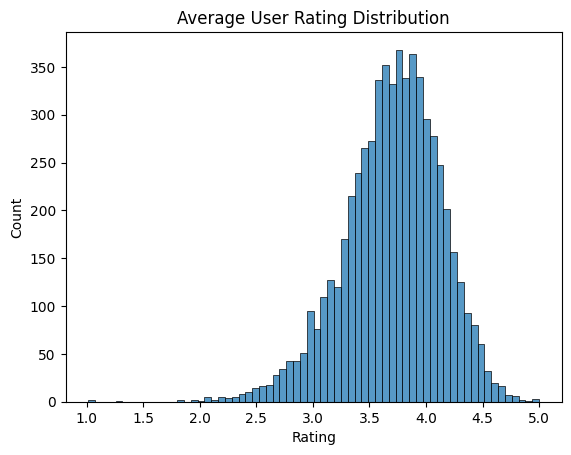

In [36]:
sns.histplot(avgUserRating['Rating'])
plt.title("Average User Rating Distribution")
plt.show()

In [37]:
# Age group which have watched and rated most number of movies
ageGroupCount = pd.DataFrame(final_df.groupby(['Age'])['Rating'].count())
ageGroupCount.reset_index(inplace=True)
ageGroupCount.rename(columns={'Rating':'Total_Ratings'}, inplace = True)
ageGroupCount['Rating_Percentage'] = np.round(ageGroupCount['Total_Ratings'] * 100 / final_df['Rating'].count(), 2)
ageGroupCount

,Age,Total_Ratings,Rating_Percentage
0,18-24,183047,18.38
1,25-34,394105,39.56
2,35-44,198084,19.89
3,45-49,83161,8.35
4,50-55,72071,7.23
5,56 Above,38544,3.87
6,Under 18,27132,2.72


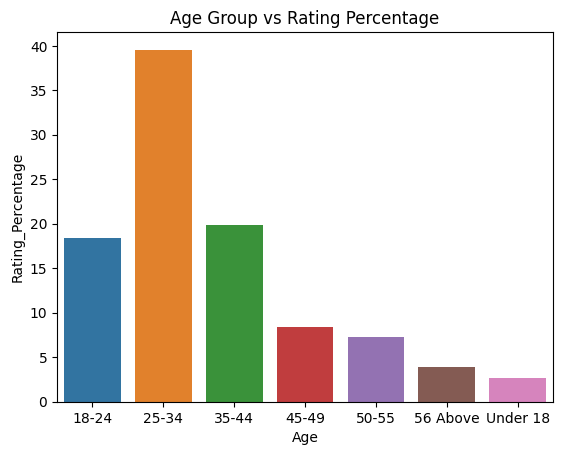

In [38]:
sns.barplot(x = ageGroupCount['Age'], y = ageGroupCount['Rating_Percentage'])
plt.title('Age Group vs Rating Percentage')
plt.show()

**Observations :** Users of age group 25-34 watched and rated most of the movies

In [39]:
# Users belonging to which profession have watched and rated the most movies?
profession = pd.DataFrame(final_df.groupby(['Occupation'])['Rating'].count())
profession.reset_index(inplace=True)
profession.rename(columns={'Rating':'Total_Ratings'}, inplace = True)
profession['Rating_Percentage'] = np.round(profession['Total_Ratings'] * 100 / final_df['Rating'].count(), 3)
profession

,Occupation,Total_Ratings,Rating_Percentage
0,K-12 student,23238,2.333
1,academic/educator,84936,8.526
2,artist,49823,5.002
3,clerical/admin,31520,3.164
4,college/grad student,130626,13.113
5,customer service,21781,2.187
6,doctor/health care,37040,3.718
7,executive/managerial,105013,10.542
8,farmer,2692,0.270
9,homemaker,11312,1.136


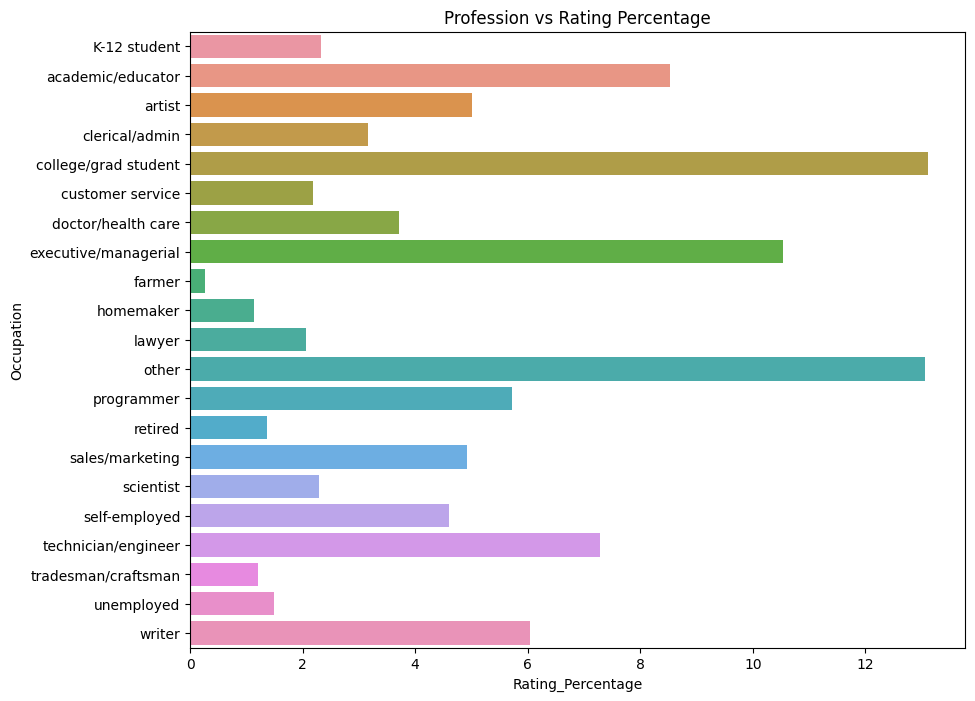

In [40]:
plt.figure(figsize = (10,8))
sns.barplot(y = profession['Occupation'], x = profession['Rating_Percentage'],orient='h')
plt.title("Profession vs Rating Percentage")
plt.show()

**Observations :** College/grad students rated most movies.

In [41]:
# Gender of the users in our dataset who’ve rated the movies
gender_dsbn = pd.DataFrame(final_df.groupby(['Gender'])['Rating'].count())
gender_dsbn.reset_index(inplace=True)
gender_dsbn.rename(columns={'Rating':'Total_Ratings'}, inplace = True)
gender_dsbn['Rating_Percentage'] = np.round(gender_dsbn['Total_Ratings'] * 100 / final_df['Rating'].count(), 3)
gender_dsbn

,Gender,Total_Ratings,Rating_Percentage
0,F,245554,24.65
1,M,750590,75.35


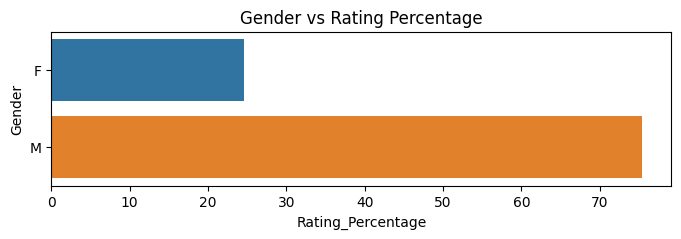

In [42]:
plt.figure(figsize = (8,2))
sns.barplot(x = gender_dsbn['Rating_Percentage'], y= gender_dsbn['Gender'],orient = 'h')
plt.title("Gender vs Rating Percentage")
plt.show()

**Observations :** Most of the users in our dataset who’ve rated the movies are Male.

In [43]:
# Most of the movies present in our dataset were released in which decade?
decade = pd.DataFrame(final_df.groupby(['Release_decade'])['Rating'].count())
decade.reset_index(inplace=True)
decade.rename(columns={'Rating':'Total_Ratings'}, inplace = True)
decade['Rating_Percentage'] = np.round(decade['Total_Ratings'] * 100 / final_df['Rating'].count(), 3)
decade

,Release_decade,Total_Ratings,Rating_Percentage
0,20s,1696,0.170
1,30s,12648,1.270
2,40s,21501,2.158
3,50s,34604,3.474
4,60s,47060,4.724
5,70s,82354,8.267
6,80s,223121,22.398
7,90s,573115,57.533


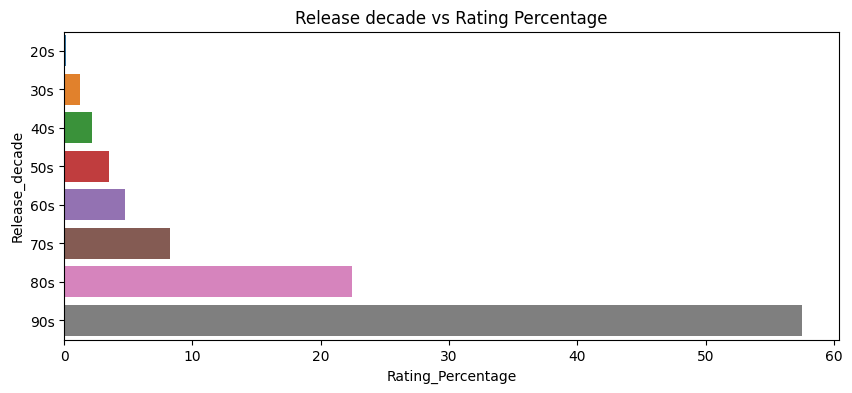

In [44]:
plt.figure(figsize = (10,4))
sns.barplot(y = decade['Release_decade'], x = decade['Rating_Percentage'],orient = 'h')
plt.title("Release decade vs Rating Percentage")
plt.show()

**Observations :** Most of the movies present in our dataset were released in 90s

In [45]:
# The movie with maximum no. of ratings
movie_dsbn = pd.DataFrame(final_df.groupby(['Title'])['Rating'].count())
movie_dsbn.reset_index(inplace=True)
movie_dsbn.rename(columns={'Rating':'Total_Ratings'}, inplace = True)
movie_dsbn['Rating_Percentage'] = np.round(movie_dsbn['Total_Ratings'] * 100 / final_df['Rating'].count(), 2)
movie_dsbn[:10]

,Title,Total_Ratings,Rating_Percentage
0,"$1,000,000 Duck",37,0.00
1,'Night Mother,70,0.01
2,'Til There Was You,52,0.01
3,"'burbs, The",303,0.03
4,...And Justice for All,199,0.02
5,1-900,2,0.00
6,10 Things I Hate About You,700,0.07
7,101 Dalmatians,929,0.09
8,12 Angry Men,616,0.06
9,"13th Warrior, The",750,0.08


In [46]:
top15Movies=movie_dsbn[['Title', 'Total_Ratings']].sort_values(by = 'Total_Ratings',ascending = False).head(15)
top15Movies

,Title,Total_Ratings
125,American Beauty,3428
3099,Star Wars: Episode IV - A New Hope,2991
3100,Star Wars: Episode V - The Empire Strikes Back,2990
3101,Star Wars: Episode VI - Return of the Jedi,2883
1761,Jurassic Park,2672
2843,Saving Private Ryan,2653
3238,Terminator 2: Judgment Day,2649
2075,"Matrix, The",2590
256,Back to the Future,2583
2936,"Silence of the Lambs, The",2578


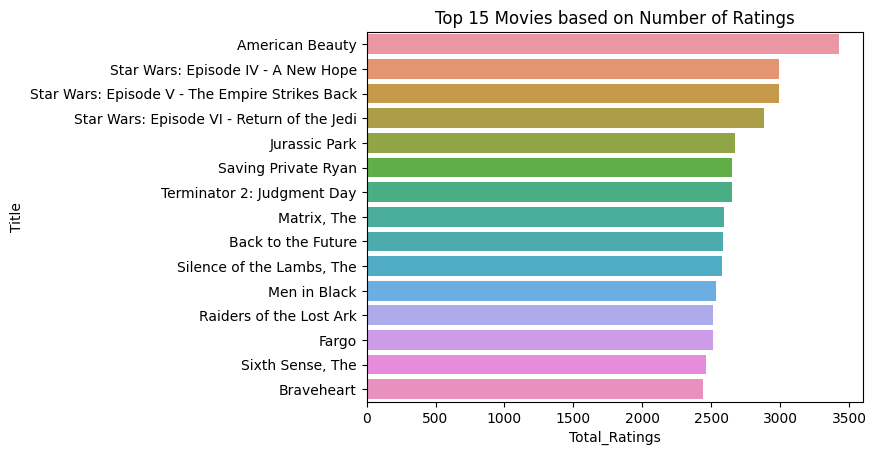

In [47]:
sns.barplot(y = top15Movies['Title'], x = top15Movies['Total_Ratings'])
plt.title("Top 15 Movies based on Number of Ratings")
plt.show()

**Observations :** The movie with maximum no. of ratings is Americal Beauty.

### **Functions**

In [48]:
# Item-based Collaborative Filtering
def item_based_cf(pt):
    similarity_matrix = cosine_similarity(pt)
    return similarity_matrix

# User-based Collaborative Filtering
def user_based_cf(pt):
    user_similarity_matrix = cosine_similarity(pt)
    return user_similarity_matrix

# Pearson Correlation
def pearson_correlation(pt):
    user_correlation_matrix = pt.corr(method='pearson')
    return user_correlation_matrix

# Nearest Neighbors using Cosine Similarity
def nearest_neighbors_cosine(pt, k=10):
    neighbor_distance_matrix = pairwise_distances(pt, metric='cosine')
    neighbor_similarity_matrix = 1 - neighbor_distance_matrix
    k_neighbors_matrix = np.zeros_like(neighbor_similarity_matrix)
    for i in range(pt.shape[0]):
        k_neighbors_matrix[i, np.argsort(neighbor_similarity_matrix[i])[:-k-1:-1]] = 1
    return k_neighbors_matrix

#  Matrix Factorization
def matrix_factorization(pt, k=50):
    user_ratings_mean = np.mean(pt, axis=1)
    ratings_demeaned = pt - user_ratings_mean.reshape(-1, 1)
    U, sigma, Vt = svds(ratings_demeaned, k=k)
    sigma = np.diag(sigma)
    predicted_pt = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    return predicted_pt

def item_based_cf_pearson(pt):
    similarity_matrix = np.zeros((pt.shape[1], pt.shape[1]))
    for i in range(pt.shape[1]):
        for j in range(pt.shape[1]):
            similarity_matrix[i,j] = 1 - correlation(pt.iloc[:,i], pt.iloc[:,j], method='pearson')
    return similarity_matrix



# Build a Recommender System based on Pearson Correlation

Creating a pivot table of movie titles & user id and imputing the NaN values

### **a)  Use the Item-based approach to create a  recommender system that uses Pearson Correlation**

In [49]:
pivoteTable = pd.pivot_table(final_df, index = 'UserID', columns='Title', values='Rating', aggfunc='mean')
pivoteTable.fillna(0, inplace = True)
pivoteTable.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
pivoteTable.shape

(6040, 3640)

In [51]:
sparsity = round(1.0 - final_df.shape[0] / float( final_df['UserID'].nunique() * final_df['MovieID'].nunique()), 3)
print('The sparsity level of dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of dataset is 95.5%


In [52]:
# Item based similarity Matrix
itemSimilarity = cosine_similarity(pivoteTable.T)
itemBasedSimilarityMatrix = pd.DataFrame(itemSimilarity, index = pivoteTable.columns, columns=pivoteTable.columns)
itemBasedSimilarityMatrix.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


In [53]:
# function to return top 5 recommendations for a given item based on correlation coefficient
def similarMoviesBasedOnPeasronCorr(moviename):
    movieMatrix = pivoteTable[moviename]
    similarMovies = pd.DataFrame(pivoteTable.corrwith(movieMatrix))
    similarMovies.head()
    similarMovies.rename(columns={0 : "Correlation"}, inplace=True)
    similarMovies.reset_index(inplace=True)
    similarMovies.sort_values(by='Correlation', ascending=False, inplace=True)
    return similarMovies[0:6]

In [54]:
similarMoviesBasedOnPeasronCorr('101 Dalmatians')[1:6]

,Title,Correlation
274,Bambi,0.463776
2534,Pinocchio,0.459928
675,Cinderella,0.459570
991,Dumbo,0.457344
2511,Peter Pan,0.447094


For the movie 101 Dalmatians, the top 5 recommended movies are - Bambi, Pinocchio, Cindrella, Dumbo and Peter Pan

### **b)  Use the User-based approach to create a recommender system that uses Pearson Correlation**

In [55]:
# User based similarity Matrix
userBased = cosine_similarity(pivoteTable)
userBasedMatrix = pd.DataFrame(userBased, index=pivoteTable.index, columns=pivoteTable.index)
userBasedMatrix.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.096382,0.120610,0.132455,0.090158,0.181240,0.059678,0.138241,0.226148,0.255319,...,0.170588,0.082006,0.090961,0.033663,0.114877,0.187913,0.137029,0.000000,0.176834,0.134765
2,0.096382,1.000000,0.151479,0.171176,0.114394,0.102000,0.305787,0.211120,0.190198,0.228266,...,0.112503,0.091222,0.268565,0.014286,0.183384,0.230182,0.207867,0.066118,0.067306,0.220196
3,0.120610,0.151479,1.000000,0.151227,0.062907,0.075443,0.138332,0.077656,0.126457,0.214978,...,0.092960,0.125864,0.161507,0.000000,0.097308,0.144482,0.108576,0.120234,0.095884,0.134315
4,0.132455,0.171176,0.151227,1.000000,0.045094,0.013681,0.130339,0.100856,0.093651,0.121485,...,0.163629,0.093041,0.382803,0.000000,0.082097,0.172033,0.128448,0.062907,0.065460,0.139181
5,0.090158,0.114394,0.062907,0.045094,1.000000,0.047983,0.126257,0.220817,0.261330,0.117777,...,0.100652,0.035732,0.065278,0.054151,0.179083,0.295859,0.174020,0.020459,0.028042,0.243560


In [56]:
pt = pivoteTable.T

In [57]:
# function to return top 5 recommendations for a given user based on correlation coefficient
def similarUsersBasedOnPeasronCorr(userid):
    userMatrix = pt[userid]
    similarusers = pd.DataFrame(pt.corrwith(userMatrix))
    similarusers.head()
    similarusers.rename(columns={0 : "Correlation"}, inplace=True)
    similarusers.reset_index(inplace=True)
    similarusers.sort_values(by='Correlation', ascending=False, inplace=True)
    return similarusers[0:6]

In [58]:
similarUsersBasedOnPeasronCorr(45)[1:6]

,UserID,Correlation
593,594,0.409388
730,731,0.363672
758,759,0.354873
5887,5888,0.344343
1882,1883,0.343820


Top similar users for userid 4 are users with id 594, 731, 759, 5888 and 1883.

# Build a Recommender System based on Nearest Neighbors algorithm and Cosine Similarity.


Print the user similarity matrix and item similarity matrix

### **a) Using the Item-based approach**

In [59]:
nearestNeighbours = NearestNeighbors(metric='cosine')
nearestNeighbours.fit(pivoteTable.T)
distances, indices = nearestNeighbours.kneighbors(pivoteTable.T, n_neighbors= 6)
indices = pd.DataFrame(indices, columns=['Movie1', 'Movie2', 'Movie3', 'Movie4', 'Movie5','Movie6'])
indices.head()

,Movie1,Movie2,Movie3,Movie4,Movie5,Movie6
0,0,735,416,286,584,3247
1,1,807,72,2167,3036,3369
2,2,1627,2529,3320,2588,1999
3,3,1457,2169,1308,1047,3511
4,4,26,726,894,495,944


In [60]:
# function to return top 5 recommendations for a given item
ans = indices.copy()
for i in range(1, 7):
    movie = pd.DataFrame(pivoteTable.T.index).reset_index()
    movie = movie.rename(columns={'index':f'Movie{i}'})
    ans = pd.merge(ans, movie, on=[f'Movie{i}'], how='left')
    ans = ans.drop(f'Movie{i}', axis=1)
    ans = ans.rename(columns={'Title':f'Movie{i}'})
ans.head()

,Movie1,Movie2,Movie3,Movie4,Movie5,Movie6
0,"$1,000,000 Duck","Computer Wore Tennis Shoes, The",Blackbeard's Ghost,"Barefoot Executive, The",Candleshoe,That Darn Cat!
1,'Night Mother,"Cry in the Dark, A",Agnes of God,Mommie Dearest,Sophie's Choice,"Trip to Bountiful, The"
2,'Til There Was You,If Lucy Fell,Picture Perfect,To Gillian on Her 37th Birthday,Practical Magic,Mad Love
3,"'burbs, The",Harry and the Hendersons,"Money Pit, The",Ghostbusters II,European Vacation,Weekend at Bernie's
4,...And Justice for All,52 Pick-Up,Coma,Deliverance,"Boys from Brazil, The",Dog Day Afternoon


In [61]:
movie_name = input("Enter a movie name : ")
ans[ans['Movie1'] == movie_name]

Enter a movie name :  101 Dalmatians


,Movie1,Movie2,Movie3,Movie4,Movie5,Movie6
7,101 Dalmatians,Bambi,Cinderella,Dumbo,Pinocchio,Peter Pan


In [62]:
nearestNeighbours = NearestNeighbors(metric='cosine')
nearestNeighbours.fit(pivoteTable)
distances, indices = nearestNeighbours.kneighbors(pivoteTable, n_neighbors= 6)
indices = pd.DataFrame(indices, columns=['UserID1', 'UserID2', 'UserID3', 'UserID4', 'UserID5','UserID6'])
indices.head()

,UserID1,UserID2,UserID3,UserID4,UserID5,UserID6
0,0,5342,5189,1480,1282,5704
1,1,3107,94,2813,4600,2302
2,2,2999,5690,478,3499,4319
3,3,4142,1574,561,5875,86
4,4,1483,5451,5748,4606,224


For user with ID = 0 , the top users with similarity are users having ID - 5342,  5189,  1480,  1282  and 5704.

# Build a Recommender System based on Matrix Factorization.

Create a Recommender System using the Matrix Factorization method

Evaluate the model in terms of the Root Mean Squared Error and Mean Absolute Percentage Error

Use embeddings for visualization and similarity-based models.


In [63]:
df = final_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
userMatrix = final_df[['UserID', 'MovieID', 'Rating']].copy()
userMatrix.columns = ['UserId', 'ItemId', 'Rating']
userMatrix.head()

,UserId,ItemId,Rating
0,1,1,5
1,1,48,5
2,1,150,5
3,1,260,4
4,1,527,5


In [65]:
userMatrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996144 entries, 0 to 996143
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   UserId  996144 non-null  int32
 1   ItemId  996144 non-null  int32
 2   Rating  996144 non-null  int32
dtypes: int32(3)
memory usage: 19.0 MB


In [66]:
userMatrix.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
UserId,996144.0,3024.003,1728.265,1.0,1505.0,3069.0,4476.0,6040.0
ItemId,996144.0,1867.030,1096.029,1.0,1032.0,1836.0,2770.0,3952.0
Rating,996144.0,3.580,1.117,1.0,3.0,4.0,4.0,5.0


In [67]:
model = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model.fit(userMatrix)

Collective matrix factorization model
(explicit-feedback variant)


In [68]:
# Embedded Ratings of Users and Embedded ratings of Items
model.A_.shape, model.B_.shape

((6040, 4), (3682, 4))

In [69]:
# Average rating and Global Mean
userMatrix.Rating.mean(), model.glob_mean_

(3.57998542379415, 3.5799853801727295)

In [70]:
# predicted ratings 
predicted_ratings = np.dot(model.A_, model.B_.T) + model.glob_mean_
predicted_ratings

array([[4.2827616, 4.0371356, 4.3223734, ..., 3.6493275, 3.5660408,
        3.5940168],
       [4.1723847, 4.098395 , 4.4252853, ..., 3.8183212, 3.185352 ,
        3.7828226],
       [4.2296534, 2.730298 , 4.0948124, ..., 3.6259658, 3.551785 ,
        3.6304944],
       ...,
       [4.025975 , 2.4406729, 3.5153856, ..., 3.5434008, 3.4513059,
        3.5987926],
       [4.6275587, 4.205623 , 4.616607 , ..., 3.6345565, 3.6553328,
        3.550976 ],
       [5.0702224, 3.0767355, 5.051941 , ..., 3.842269 , 3.1892602,
        3.8094964]], dtype=float32)

In [71]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# RMSE value 
rmse = mean_squared_error(df.values[df > 0], predicted_ratings[df > 0], squared=False)
print('Root Mean Squared Error: {:.3f}'.format(rmse))

# MAPE value
mape =  mean_absolute_percentage_error(df.values[df > 0], predicted_ratings[df > 0])
print('Mean Absolute Percentage Error: {:.3f}'.format(mape))

Root Mean Squared Error: 1.476
Mean Absolute Percentage Error: 0.422


In [72]:
# Embeddings for user-user similarity
user=cosine_similarity(model.A_)
user_sim_matrix = pd.DataFrame(user, index=pivoteTable.index, columns=pivoteTable.index)
user_sim_matrix.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.088073,0.363078,-0.249395,0.718838,0.332625,-0.010086,-0.625572,-0.449215,-0.569905,...,-0.496325,0.714246,0.437348,-0.171099,0.747024,0.197282,0.826462,-0.311508,0.945377,0.278513
2,-0.088073,1.000000,-0.512670,0.060343,0.581220,0.332946,0.154381,-0.569656,0.040253,0.778155,...,0.520587,0.616675,0.529284,0.321486,-0.210402,-0.671947,-0.586832,-0.008255,-0.406879,0.662922
3,0.363078,-0.512670,1.000000,0.659688,-0.069559,0.485552,0.656270,0.443274,0.451820,-0.261294,...,-0.066160,-0.179580,0.426872,0.103937,0.857165,0.880987,0.506355,0.234021,0.502850,0.279745
4,-0.249395,0.060343,0.659688,1.000000,-0.195940,0.542990,0.924487,0.580668,0.891166,0.533799,...,0.604393,-0.278901,0.580906,0.369959,0.435821,0.550717,-0.294509,0.409845,-0.246904,0.562157
5,0.718838,0.581220,-0.069559,-0.195940,1.000000,0.596940,-0.019081,-0.878569,-0.454072,0.046251,...,-0.203922,0.939292,0.632261,0.281837,0.416944,-0.394899,0.316749,-0.040267,0.475994,0.678728


In [73]:
# Embedding Item Item Similarity
item=cosine_similarity(model.B_)
item_sim_matrix = pd.DataFrame(item, index=userMatrix['ItemId'].unique(), columns=userMatrix['ItemId'].unique())
item_sim_matrix.head()

,1,48,150,260,527,531,588,594,595,608,...,872,2480,3656,3172,989,3280,642,1915,3779,1832
1,1.000000,-0.058749,0.954507,0.911087,0.952640,0.666721,0.909237,0.764234,0.882831,0.659934,...,-0.184447,-0.095996,0.147259,0.494630,0.158347,-0.558085,0.217393,0.762121,-0.653695,0.603450
48,-0.058749,1.000000,0.085030,-0.385942,-0.355209,0.483500,0.360928,0.375136,0.379983,-0.481997,...,0.963261,0.543983,-0.148307,-0.425367,-0.872222,-0.610512,0.756991,-0.033797,0.273007,-0.375904
150,0.954507,0.085030,1.000000,0.880058,0.879090,0.571414,0.934890,0.666851,0.876782,0.441278,...,-0.005420,-0.229939,-0.111797,0.409813,-0.087008,-0.576731,0.199331,0.880960,-0.671111,0.683148
260,0.911087,-0.385942,0.880058,1.000000,0.975596,0.313627,0.697035,0.438496,0.621809,0.683195,...,-0.476215,-0.464876,0.030740,0.659084,0.354433,-0.202909,-0.198420,0.786868,-0.672279,0.749555
527,0.952640,-0.355209,0.879090,0.975596,1.000000,0.454423,0.743251,0.583664,0.709877,0.731476,...,-0.451188,-0.287021,0.132093,0.572249,0.385567,-0.340903,-0.036010,0.755862,-0.721564,0.713486


In [74]:
item_movie = final_df[['MovieID', 'Title']].copy()
item_movie.drop_duplicates(inplace=True)
item_movie.reset_index(drop=True,inplace=True)

movie_name=923
movie_rating = item_sim_matrix[movie_name] # # Taking the ratings of that movie
similar_movies = item_sim_matrix.corrwith(movie_rating)
sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
sim_df.sort_values('Correlation', ascending=False, inplace=True)
sim_df1= sim_df.copy()
sim_df1.reset_index(inplace=True)
sim_df1.rename(columns = {'index':'MovieID'}, inplace = True)
sim_mov = pd.merge(sim_df1,item_movie,on='MovieID',how='inner')
sim_mov.head(6)

,MovieID,Correlation,Title
0,923,1.000000,Citizen Kane
1,3470,0.998845,Dersu Uzala
2,922,0.998530,Sunset Blvd. (a.k.a. Sunset Boulevard)
3,1178,0.997779,Paths of Glory
4,3305,0.995961,Bluebeard
5,246,0.995646,Hoop Dreams


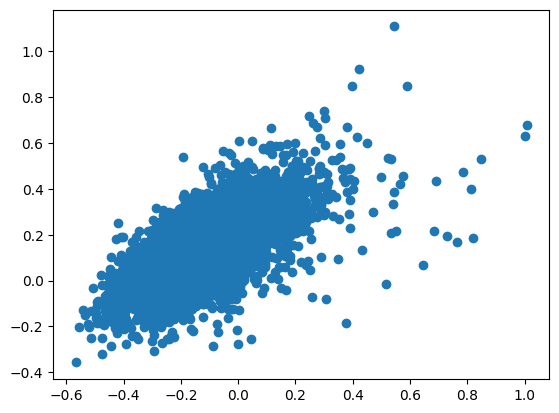

In [75]:
model1 = CMF(method="als", k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model1.fit(userMatrix)
plt.scatter(model1.A_[:, 0], model1.A_[:, 1])

We could see a positive correlation between 2 users.


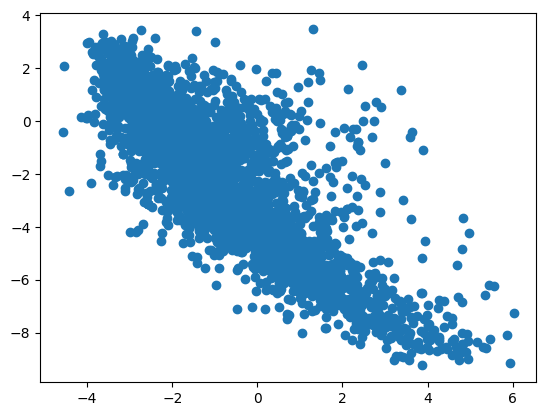

In [76]:
plt.scatter(model1.B_[:, 0], model1.B_[:, 1])
plt.show()

We could see a negative correlation between 2 items.

## **Questionaire**

1. Users of which age group have watched and rated the most number of movies? :-  **25-34 age group**

2. Users belonging to which profession have watched and rated the most movies? :-  **college/grad students**

3. Most of the users in our dataset who’ve rated the movies are Male. (T/F):- **True**

4. Most of the movies present on our dataset were released in which decade? 

    * a) 70s		
    * b) 90s	
    * c) 50s		
    * d) 80s
    
    -->  **Most of the movies present in dataset were released in 90s.**

5. The movie with maximum no. of ratings is ___ :- **American Beauty**

6. Name the top 3 movies similar to **'Liar Liar’** on the item-based approach. :-

-- >  **Mrs. Doubtfire, Detective Dumb & Dumber, Ace Ventura: Pet Detective**

In [77]:
similarMoviesBasedOnPeasronCorr('Liar Liar')[1:4]

,Title,Correlation
2207,Mrs. Doubtfire,0.499927
990,Dumb & Dumber,0.459601
43,Ace Ventura: Pet Detective,0.458654


7. On the basis of approach, Collaborative Filtering methods can be classified into **Memory-based** and **Model-based**.

8. Pearson Correlation ranges between **-1 to 1** whereas, Cosine Similarity belongs to the interval between **-1 to 1**

9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.:- **RMSE:1.476  and MAPE: 0.422**

10. Give the sparse ‘row’ matrix representation for the following dense matrix - [[1 0],[ 3 7]]


In [78]:
from scipy.sparse import csr_matrix
A = np.array([[1,0],[3,7]])
S = csr_matrix(A)
print(S)

  (0, 0)	1
  (1, 0)	3
  (1, 1)	7


---
**By Mrudula A P**